In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
import scipy.io as sio
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [8]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [9]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [10]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

In [11]:
def build_cnn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', 
                  activation='relu', input_shape=input_shape))  
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid', 
                          activation='relu'))  
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
        model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [11]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.2842 - acc: 0.2802
Epoch 00001: val_loss improved from inf to 1.81365, saving model to model/checkpoint/1D_CNN_1_conv_1_fcn_checkpoint/01-1.8136.hdf5
36805/36805 [==============================] - 20s 547us/sample - loss: 2.2841 - acc: 0.2802 - val_loss: 1.8136 - val_acc: 0.4405
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6030 - acc: 0.4975
Epoch 00002: val_loss improved from 1.81365 to 1.42739, saving model to model/checkpoint/1D_CNN_1_conv_1_fcn_checkpoint/02-1.4274.hdf5
36805/36805 [==============================] - 20s 530us/sample - loss: 1.6031 - acc: 0.4975 - val_loss: 1.4274 - val_acc: 0.565

Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9841
Epoch 00025: val_loss did not improve from 1.00593
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0730 - acc: 0.9841 - val_loss: 1.2144 - val_acc: 0.7025
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0678 - acc: 0.9855
Epoch 00026: val_loss did not improve from 1.00593
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0677 - acc: 0.9855 - val_loss: 1.1810 - val_acc: 0.7102
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9851
Epoch 00027: val_loss did not improve from 1.00593
36805/36805 [==============================] - 19s 520us/sample - loss: 0.0698 - acc: 0.9851 - val_loss: 1.2356 - val_acc: 0.7049
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9841
Epoch 00028: val_loss did not improve from 1.00593
36805/36805 [=====

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9922
Epoch 00055: val_loss did not improve from 1.00593
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0330 - acc: 0.9922 - val_loss: 1.4071 - val_acc: 0.7172
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9932
Epoch 00056: val_loss did not improve from 1.00593
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0313 - acc: 0.9932 - val_loss: 1.3844 - val_acc: 0.7198
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9935
Epoch 00057: val_loss did not improve from 1.00593
36805/36805 [==============================] - 19s 520us/sample - loss: 0.0292 - acc: 0.9935 - val_loss: 1.4141 - val_acc: 0.7256
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9939
Epoch 00058: val_loss did not improve from 1.00593
36805/36805 [=====

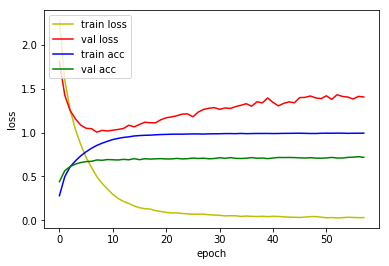

4815/4815 [==============================] - 1s 176us/sample - loss: 1.1035 - acc: 0.6648
Loss: 1.1035148400507735 Accuracy: 0.6647975

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.4692 - acc: 0.2076
Epoch 00001: val_loss improved from inf to 1.91109, saving model to model/checkpoint/1D_CNN_1_conv_2_fcn_checkpoint/01-1.9111.hdf5
36805/36805 [==============================] - 20s 544us/sample - loss: 2.4691 - acc: 0.2076 - val_loss: 1.9111 - val_acc: 0.4205
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7688 - acc: 0.4230
Epoch 00002: val_loss improved from 1.91109 to 1.40289, saving model to model/checkpoint/1D_CNN_1_conv_2_fcn_checkpoint/02-1.4029.hdf5
36805/36805 [==============================] - 20s 541us/sample - loss: 1.7688 - acc: 0.4230 - val_loss: 1.4029 - val_acc: 0.5639
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4085 - acc: 0.5385
E

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9887
Epoch 00057: val_loss did not improve from 0.79239
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0397 - acc: 0.9887 - val_loss: 1.2241 - val_acc: 0.7696
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9894
Epoch 00058: val_loss did not improve from 0.79239
36805/36805 [==============================] - 20s 532us/sample - loss: 0.0362 - acc: 0.9894 - val_loss: 1.2265 - val_acc: 0.7706
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9895
Epoch 00059: val_loss did not improve from 0.79239
36805/36805 [==============================] - 20s 533us/sample - loss: 0.0362 - acc: 0.9895 - val_loss: 1.2070 - val_acc: 0.7720

1 Conv 2 FCN Model


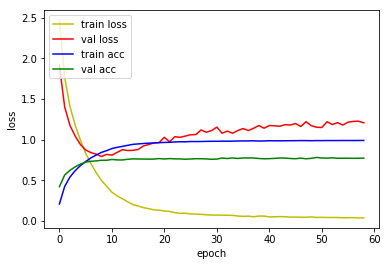

4815/4815 [==============================] - 1s 170us/sample - loss: 0.9907 - acc: 0.7078
Loss: 0.990710443276854 Accuracy: 0.70778817

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.0858 - acc: 0.3304
Epoch 00001: val_loss improved from inf to 1.59139, saving model to model/checkpoint/1D_CNN_2_conv_1_fcn_checkpoint/01-1.5914.hdf5
36805/36805 [==============================] - 18s 491us/sample - loss: 2.0857 - acc: 0.3304 - val_loss: 1.5914 - val_acc: 0.4913
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4967 - acc: 0.5174
Epoch 00002: val_loss improved from 1.59139 to 1.29067, saving model to model/checkpoint/1D_CNN_2_conv_1_fcn_checkpoint/02-1.2907.hdf5
36805/36805 [==============================] - 18s 483us/sample - loss: 1.4967 - acc: 0.5174 - val_loss: 1.2907 - val_acc: 0.5991
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2126 - acc: 0.6139
E

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9860
Epoch 00027: val_loss did not improve from 0.69000
36805/36805 [==============================] - 17s 468us/sample - loss: 0.0536 - acc: 0.9860 - val_loss: 0.8696 - val_acc: 0.7950
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9863
Epoch 00028: val_loss did not improve from 0.69000
36805/36805 [==============================] - 17s 472us/sample - loss: 0.0521 - acc: 0.9863 - val_loss: 0.9135 - val_acc: 0.7897
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9870
Epoch 00029: val_loss did not improve from 0.69000
36805/36805 [==============================] - 18s 481us/sample - loss: 0.0499 - acc: 0.9870 - val_loss: 0.8878 - val_acc: 0.7976
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9883
Epoch 00030: val_loss did not improve from 0.69000
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.69000
36805/36805 [==============================] - 17s 466us/sample - loss: 0.0178 - acc: 0.9951 - val_loss: 0.9845 - val_acc: 0.8092
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9958
Epoch 00058: val_loss did not improve from 0.69000
36805/36805 [==============================] - 17s 467us/sample - loss: 0.0165 - acc: 0.9958 - val_loss: 1.0212 - val_acc: 0.8060
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9952
Epoch 00059: val_loss did not improve from 0.69000
36805/36805 [==============================] - 17s 471us/sample - loss: 0.0179 - acc: 0.9952 - val_loss: 1.0608 - val_acc: 0.8015
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9957
Epoch 00060: val_loss did not improve from 0.69000
36805/36805 [=====

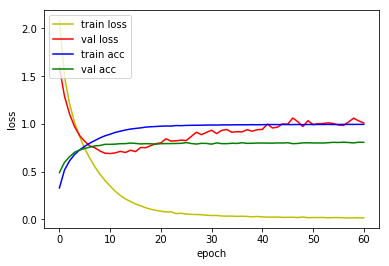

4815/4815 [==============================] - 1s 202us/sample - loss: 0.7646 - acc: 0.7688
Loss: 0.7645713621210829 Accuracy: 0.76884735

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.2373 - acc: 0.2728
Epoch 00001: val_loss improved from inf to 1.66980, saving model to model/checkpoint/1D_CNN_2_conv_2_fcn_checkpoint/01-1.6698.hdf5
36805/36805 [==============================] - 19s 507us/sample - loss: 2.2374 - acc: 0.2727 - val_loss: 1.6698 - val_acc: 0.4659
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6102 - acc: 0.4689
Epoch 00002: val_loss improved from 1.66980 to 1.27805, saving model to model/checkpoint/1D_CNN_2_conv_2_fcn_checkpoint/02-1.2780.hdf5
36805/36805 [==============================] - 18s 481us/sample - loss: 1.6102 - acc: 0.4689 - val_loss: 1.2780 - val_acc: 0.5914
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3068 - acc: 0.5682


Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9794
Epoch 00027: val_loss did not improve from 0.57163
36805/36805 [==============================] - 18s 479us/sample - loss: 0.0674 - acc: 0.9794 - val_loss: 0.7193 - val_acc: 0.8281
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9805
Epoch 00028: val_loss did not improve from 0.57163
36805/36805 [==============================] - 18s 479us/sample - loss: 0.0645 - acc: 0.9805 - val_loss: 0.7705 - val_acc: 0.8216
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9822
Epoch 00029: val_loss did not improve from 0.57163
36805/36805 [==============================] - 18s 480us/sample - loss: 0.0624 - acc: 0.9822 - val_loss: 0.7735 - val_acc: 0.8290
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9819
Epoch 00030: val_loss did not improve from 0.57163
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9934
Epoch 00057: val_loss did not improve from 0.57163
36805/36805 [==============================] - 18s 479us/sample - loss: 0.0222 - acc: 0.9934 - val_loss: 0.9226 - val_acc: 0.8348
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9922
Epoch 00058: val_loss did not improve from 0.57163
36805/36805 [==============================] - 18s 479us/sample - loss: 0.0244 - acc: 0.9922 - val_loss: 0.8675 - val_acc: 0.8316
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9938
Epoch 00059: val_loss did not improve from 0.57163
36805/36805 [==============================] - 18s 480us/sample - loss: 0.0201 - acc: 0.9938 - val_loss: 0.8724 - val_acc: 0.8393
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9923
Epoch 00060: val_loss did not improve from 0.57163
36805/36805 [=====

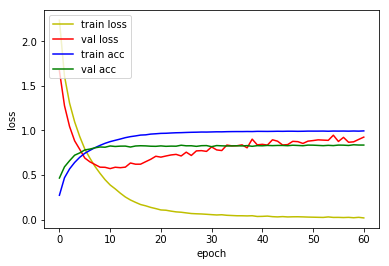

4815/4815 [==============================] - 1s 218us/sample - loss: 0.6464 - acc: 0.8056
Loss: 0.6464458153131472 Accuracy: 0.8056075

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.0545 - acc: 0.3342
Epoch 00001: val_loss improved from inf to 1.46230, saving model to model/checkpoint/1D_CNN_3_conv_1_fcn_checkpoint/01-1.4623.hdf5
36805/36805 [==============================] - 18s 477us/sample - loss: 2.0537 - acc: 0.3345 - val_loss: 1.4623 - val_acc: 0.5260
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3797 - acc: 0.5562
Epoch 00002: val_loss improved from 1.46230 to 1.07381, saving model to model/checkpoint/1D_CNN_3_conv_1_fcn_checkpoint/02-1.0738.hdf5
36805/36805 [==============================] - 17s 448us/sample - loss: 1.3796 - acc: 0.5562 - val_loss: 1.0738 - val_acc: 0.6732
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1099 - acc: 0.6518
E

Epoch 53/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9901
Epoch 00053: val_loss did not improve from 0.31214
36805/36805 [==============================] - 17s 448us/sample - loss: 0.0325 - acc: 0.9901 - val_loss: 0.4216 - val_acc: 0.9122
Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9911
Epoch 00054: val_loss did not improve from 0.31214
36805/36805 [==============================] - 16s 448us/sample - loss: 0.0290 - acc: 0.9911 - val_loss: 0.4021 - val_acc: 0.9089
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9922
Epoch 00055: val_loss did not improve from 0.31214
36805/36805 [==============================] - 16s 447us/sample - loss: 0.0271 - acc: 0.9922 - val_loss: 0.4115 - val_acc: 0.9124
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9926
Epoch 00056: val_loss did not improve from 0.31214
36805/36805 [=====

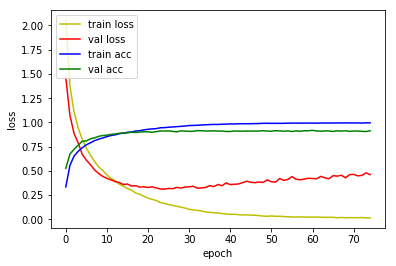

4815/4815 [==============================] - 1s 240us/sample - loss: 0.4196 - acc: 0.8717
Loss: 0.4196387409792511 Accuracy: 0.8716511

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.2165 - acc: 0.2712
Epoch 00001: val_loss improved from inf to 1.55370, saving model to model/checkpoint/1D_CNN_3_conv_2_fcn_checkpoint/01-1.5537.hdf5
36805/36805 [==============================] - 18s 494us/sample - loss: 2.2158 - acc: 0.2714 - val_loss: 1.5537 - val_acc: 0.5069
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.5404 - acc: 0.4898
Epoch 00002: val_loss improved from 1.55370 to 1.16712, saving model to model/checkpoint/1D_CNN_3_conv_2_fcn_checkpoint/02-1.1671.hdf5
36805/36805 [==============================] - 17s 452us/sample - loss: 1.5401 - acc: 0.4898 - val_loss: 1.1671 - val_acc: 0.6219
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2593 - acc: 0.5904
E

36800/36805 [============================>.] - ETA: 0s - loss: 0.1337 - acc: 0.9557
Epoch 00025: val_loss did not improve from 0.36511
36805/36805 [==============================] - 17s 460us/sample - loss: 0.1337 - acc: 0.9557 - val_loss: 0.3733 - val_acc: 0.8952
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9585
Epoch 00026: val_loss did not improve from 0.36511
36805/36805 [==============================] - 17s 459us/sample - loss: 0.1251 - acc: 0.9585 - val_loss: 0.3804 - val_acc: 0.8949
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9642
Epoch 00027: val_loss did not improve from 0.36511
36805/36805 [==============================] - 17s 459us/sample - loss: 0.1110 - acc: 0.9642 - val_loss: 0.3968 - val_acc: 0.8901
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9676
Epoch 00028: val_loss did not improve from 0.36511
36805/36805 [==================

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9917
Epoch 00055: val_loss did not improve from 0.36511
36805/36805 [==============================] - 17s 457us/sample - loss: 0.0263 - acc: 0.9917 - val_loss: 0.5148 - val_acc: 0.8954
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.36511
36805/36805 [==============================] - 17s 456us/sample - loss: 0.0271 - acc: 0.9915 - val_loss: 0.4704 - val_acc: 0.8996
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9923
Epoch 00057: val_loss did not improve from 0.36511
36805/36805 [==============================] - 17s 458us/sample - loss: 0.0247 - acc: 0.9923 - val_loss: 0.5061 - val_acc: 0.8947
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9921
Epoch 00058: val_loss did not improve from 0.36511
36805/36805 [=====

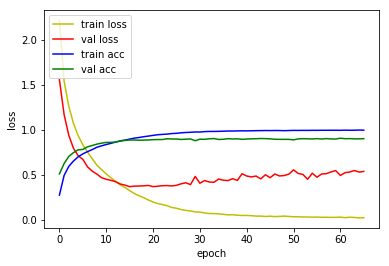

4815/4815 [==============================] - 1s 247us/sample - loss: 0.4532 - acc: 0.8702
Loss: 0.45320871350426045 Accuracy: 0.8701973

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.9888 - acc: 0.3571
Epoch 00001: val_loss improved from inf to 1.27040, saving model to model/checkpoint/1D_CNN_4_conv_1_fcn_checkpoint/01-1.2704.hdf5
36805/36805 [==============================] - 18s 494us/sample - loss: 1.9888 - acc: 0.3571 - val_loss: 1.2704 - val_acc: 0.6054
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1975 - acc: 0.6218
Epoch 00002: val_loss improved from 1.27040 to 0.89826, saving model to model/checkpoint/1D_CNN_4_conv_1_fcn_checkpoint/02-0.8983.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 1.1974 - acc: 0.6220 - val_loss: 0.8983 - val_acc: 0.7242
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9474 - acc: 0.7016


Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9893
Epoch 00054: val_loss did not improve from 0.27399
36805/36805 [==============================] - 16s 445us/sample - loss: 0.0344 - acc: 0.9893 - val_loss: 0.3479 - val_acc: 0.9334
Epoch 55/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9869
Epoch 00055: val_loss did not improve from 0.27399
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0406 - acc: 0.9869 - val_loss: 0.3814 - val_acc: 0.9306
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9906
Epoch 00056: val_loss did not improve from 0.27399
36805/36805 [==============================] - 16s 444us/sample - loss: 0.0329 - acc: 0.9906 - val_loss: 0.3941 - val_acc: 0.9224
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9893
Epoch 00057: val_loss did not improve from 0.27399
36805/36805 [=====

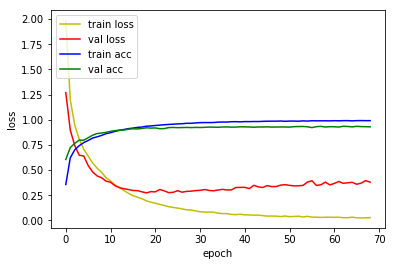

4815/4815 [==============================] - 1s 282us/sample - loss: 0.3857 - acc: 0.8945
Loss: 0.3857372078692554 Accuracy: 0.8944964

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1818 - acc: 0.2811
Epoch 00001: val_loss improved from inf to 1.48738, saving model to model/checkpoint/1D_CNN_4_conv_2_fcn_checkpoint/01-1.4874.hdf5
36805/36805 [==============================] - 19s 526us/sample - loss: 2.1816 - acc: 0.2812 - val_loss: 1.4874 - val_acc: 0.5383
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4277 - acc: 0.5290
Epoch 00002: val_loss improved from 1.48738 to 1.06638, saving model to model/checkpoint/1D_CNN_4_conv_2_fcn_checkpoint/02-1.0664.hdf5
36805/36805 [==============================] - 17s 451us/sample - loss: 1.4275 - acc: 0.5290 - val_loss: 1.0664 - val_acc: 0.6450
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0992 - acc: 0.6401
E

Epoch 24/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9522
Epoch 00024: val_loss did not improve from 0.23667
36805/36805 [==============================] - 17s 460us/sample - loss: 0.1477 - acc: 0.9522 - val_loss: 0.2367 - val_acc: 0.9338
Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9558
Epoch 00025: val_loss did not improve from 0.23667
36805/36805 [==============================] - 17s 456us/sample - loss: 0.1333 - acc: 0.9558 - val_loss: 0.2476 - val_acc: 0.9315
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9579
Epoch 00026: val_loss did not improve from 0.23667
36805/36805 [==============================] - 17s 458us/sample - loss: 0.1275 - acc: 0.9579 - val_loss: 0.2423 - val_acc: 0.9329
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1193 - acc: 0.9605
Epoch 00027: val_loss did not improve from 0.23667
36805/36805 [=====

Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9883
Epoch 00054: val_loss did not improve from 0.23667
36805/36805 [==============================] - 16s 446us/sample - loss: 0.0363 - acc: 0.9883 - val_loss: 0.3357 - val_acc: 0.9355
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9889
Epoch 00055: val_loss did not improve from 0.23667
36805/36805 [==============================] - 16s 447us/sample - loss: 0.0352 - acc: 0.9889 - val_loss: 0.2945 - val_acc: 0.9378
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9880
Epoch 00056: val_loss did not improve from 0.23667
36805/36805 [==============================] - 16s 448us/sample - loss: 0.0393 - acc: 0.9880 - val_loss: 0.3172 - val_acc: 0.9390
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9900
Epoch 00057: val_loss did not improve from 0.23667
36805/36805 [=====

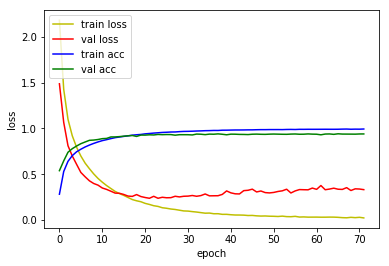

4815/4815 [==============================] - 1s 286us/sample - loss: 0.3633 - acc: 0.9038
Loss: 0.36333452287368934 Accuracy: 0.90384215

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.9696 - acc: 0.3559
Epoch 00001: val_loss improved from inf to 1.27433, saving model to model/checkpoint/1D_CNN_5_conv_1_fcn_checkpoint/01-1.2743.hdf5
36805/36805 [==============================] - 20s 534us/sample - loss: 1.9696 - acc: 0.3559 - val_loss: 1.2743 - val_acc: 0.5956
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1585 - acc: 0.6257
Epoch 00002: val_loss improved from 1.27433 to 0.84903, saving model to model/checkpoint/1D_CNN_5_conv_1_fcn_checkpoint/02-0.8490.hdf5
36805/36805 [==============================] - 16s 433us/sample - loss: 1.1583 - acc: 0.6257 - val_loss: 0.8490 - val_acc: 0.7342
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8872 - acc: 0.7138

Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9596
Epoch 00025: val_loss did not improve from 0.25295
36805/36805 [==============================] - 16s 445us/sample - loss: 0.1192 - acc: 0.9596 - val_loss: 0.2718 - val_acc: 0.9250
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9605
Epoch 00026: val_loss did not improve from 0.25295
36805/36805 [==============================] - 16s 443us/sample - loss: 0.1163 - acc: 0.9605 - val_loss: 0.2897 - val_acc: 0.9199
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1084 - acc: 0.9629
Epoch 00027: val_loss improved from 0.25295 to 0.25234, saving model to model/checkpoint/1D_CNN_5_conv_1_fcn_checkpoint/27-0.2523.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 0.1084 - acc: 0.9629 - val_loss: 0.2523 - val_acc: 0.9287
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0980

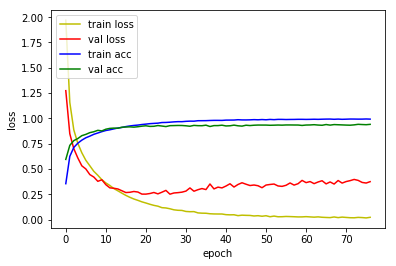

4815/4815 [==============================] - 1s 301us/sample - loss: 0.3669 - acc: 0.9047
Loss: 0.36690131204274334 Accuracy: 0.9046729

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1762 - acc: 0.2705
Epoch 00001: val_loss improved from inf to 1.54799, saving model to model/checkpoint/1D_CNN_5_conv_2_fcn_checkpoint/01-1.5480.hdf5
36805/36805 [==============================] - 21s 559us/sample - loss: 2.1762 - acc: 0.2705 - val_loss: 1.5480 - val_acc: 0.4924
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3289 - acc: 0.5611
Epoch 00002: val_loss improved from 1.54799 to 0.93847, saving model to model/checkpoint/1D_CNN_5_conv_2_fcn_checkpoint/02-0.9385.hdf5
36805/36805 [==============================] - 17s 454us/sample - loss: 1.3289 - acc: 0.5612 - val_loss: 0.9385 - val_acc: 0.6909
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9752 - acc: 0.6846


Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9904
Epoch 00055: val_loss did not improve from 0.20384
36805/36805 [==============================] - 17s 456us/sample - loss: 0.0295 - acc: 0.9904 - val_loss: 0.3032 - val_acc: 0.9457
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9912
Epoch 00056: val_loss did not improve from 0.20384
36805/36805 [==============================] - 17s 459us/sample - loss: 0.0282 - acc: 0.9913 - val_loss: 0.2861 - val_acc: 0.9457
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9892
Epoch 00057: val_loss did not improve from 0.20384
36805/36805 [==============================] - 17s 459us/sample - loss: 0.0321 - acc: 0.9892 - val_loss: 0.3259 - val_acc: 0.9420
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9908
Epoch 00058: val_loss did not improve from 0.20384
36805/36805 [=====

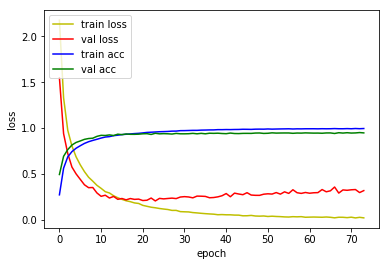

4815/4815 [==============================] - 2s 319us/sample - loss: 0.3388 - acc: 0.9090
Loss: 0.33880567779669757 Accuracy: 0.90903425



In [12]:
for i in range(1, 6):
    for j in range(1, 3):
        model = build_cnn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/1D_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print('{} Conv {} FCN Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()
        
        png_path = 'visualization/learning_curve/'
        filename = '1D_CNN_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        del(model)
        
        model_path = 'model/checkpoint/1D_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [12]:
for i in range(1, 6):
    for j in range(1, 3):
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/1D_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        print()
        print('{} Conv {} FCN Model'.format(i, j))
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        
        del(model)


1 Conv 1 FCN Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3994, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 31952)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              32719872  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
___________________

4815/4815 [==============================] - 1s 214us/sample - loss: 0.4196 - acc: 0.8717
Loss: 0.4196387409792511 Accuracy: 0.8716511

3 Conv 2 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3994, 8)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 993, 16)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 969, 32)           12832     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 243, 32)         

4815/4815 [==============================] - 1s 248us/sample - loss: 0.3669 - acc: 0.9047
Loss: 0.36690131204274334 Accuracy: 0.9046729

5 Conv 2 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 993, 16)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 969, 32)           12832     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 243, 32)        